**Teaching GPT multiple tasks at once with prompt engineering**

**Dataset** - ""[Amazon fine food review dataset](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data)""

Download .csv file only

Take the dataset to finetune a pretrained GPT model, prompts will teach attention heads and the types of tasks and how to respond a given prompt

In [1]:
"""!pip install --quiet bitsandbytes
!pip install --quiet git+https://github.com/huggingface/transformers.git # Install latest version of transformers
!pip install --quiet accelerate"""

'!pip install --quiet bitsandbytes\n!pip install --quiet git+https://github.com/huggingface/transformers.git # Install latest version of transformers\n!pip install --quiet accelerate'

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 16 19:08:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = '/content/drive/My Drive/Reviews.csv'

In [6]:
df = pd.read_csv(file_path)

In [7]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


keep useful columns only i.e. "score text summary"

In [8]:
df = df[[ 'Text', 'Summary','Score',]]

In [9]:
df.shape

(568454, 3)

In [10]:
df.tail()

,Text,Summary,Score
568449,Great for sesame chicken..this is a good if no...,Will not do without,5
568450,I'm disappointed with the flavor. The chocolat...,disappointed,2
568451,"These stars are small, so you can give 10-15 o...",Perfect for our maltipoo,5
568452,These are the BEST treats for training and rew...,Favorite Training and reward treat,5
568453,"I am very satisfied ,product is as advertised,...",Great Honey,5


<Axes: title={'center': 'Histogram of Review Length'}, ylabel='Frequency'>

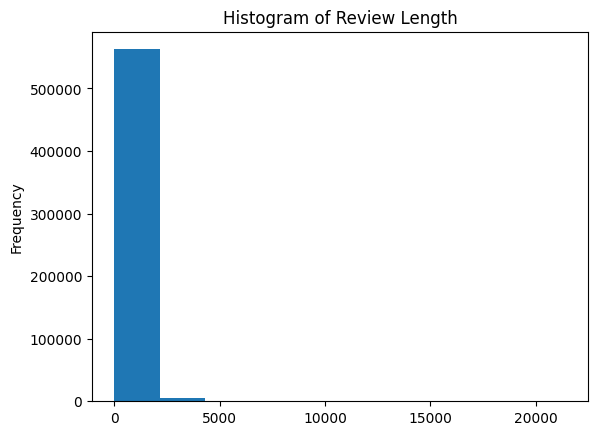

In [11]:
df['Text'].str.len().plot(kind='hist', title='Histogram of Review Length',bins= 10)

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

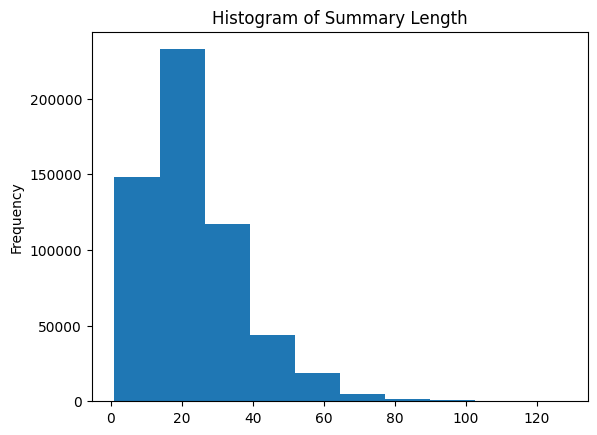

In [12]:
df['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

In [13]:
# remove very short and very long summaries
df = df[(df['Summary'].str.len() >= 10) & (df['Summary'].str.len() < 25)]

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

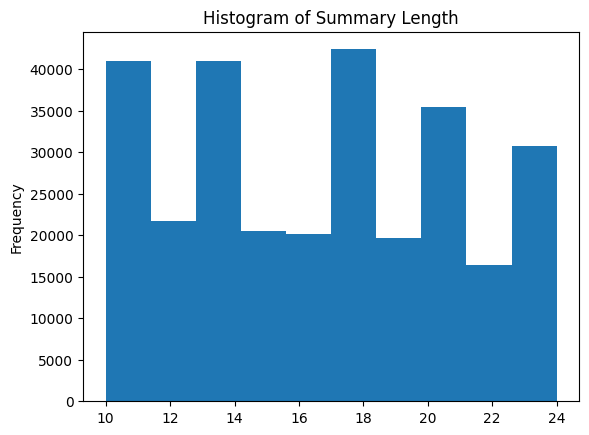

In [14]:
df['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

In [15]:
df['Sentiment'] = df['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

<Axes: >

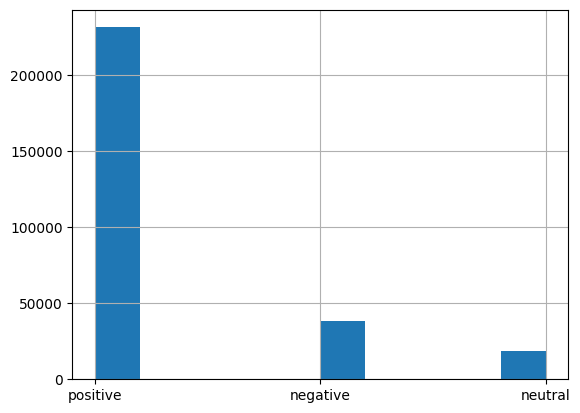

In [16]:
df['Sentiment'].hist()

In [17]:
# Take 1,000 examples from each sentiment group
df = df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))

<Axes: >

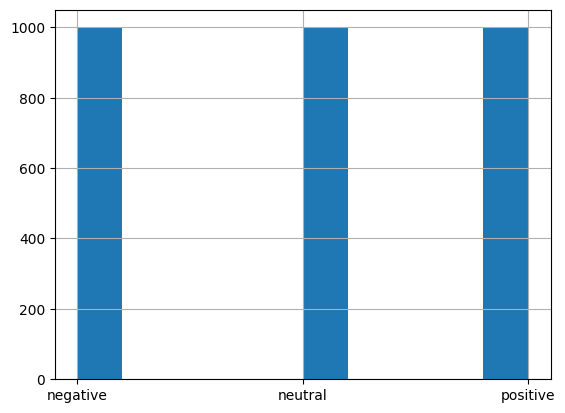

In [18]:
df['Sentiment'].hist()

DistilGPT-2" is a smaller, faster, lighter variant of the original GPT-2 model developed by OpenAI. The process of "distillation" in machine learning involves training a smaller model (often called a "student") to replicate the behavior of a larger, more complex model (referred to as the "teacher"). This approach aims to retain much of the performance of the larger model while reducing the computational resources required.

***Training Process:*** The distillation process involves training the smaller model on a combination of the original training data and the outputs (like predictions or hidden states) of the larger model. This helps the smaller model learn to mimic the larger model's behavior.

In [19]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                         GPT2Tokenizer

In [20]:
model = "distilgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**pad_token:**

pad_token is a special token used for padding sequences to a uniform length. In many NLP tasks, especially those involving neural networks, it's important that all input sequences are of the same length. If a sequence is shorter than the maximum length, pad_token is used to fill the remaining space.

**eos_token:**

eos_token stands for "end of sequence" token. It's a special token used to signify the end of a text sequence. In models like GPT-2, the eos_token is important for indicating when a model should consider a text as complete

In [21]:
tokenizer.pad_token = tokenizer.eos_token

In [22]:
#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

In [23]:
df['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + df['Text'] + SENTIMENT_TOKEN +  ' ' + df['Sentiment'].astype(str)

df['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + df['Text'] + SUMMARIZE_TOKEN +  ' ' + df['Summary'].astype(str)


In [24]:
df['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: I got a box of the Cafe Escapes Hot Chocolate with my Keurig last Christmas. I had no idea the machine made anything but coffee, so it was a welcome surprise. My girlfriend doesn\'t drink coffee but she loves hot cocoa, so I thought she would be tickled to have a cup of cocoa in three minutes flat.<br />I brewed her a cup after running the Keurig through the rinse cycle and made her a cup of cocoa in a small mug on the second-to-lowest size setting (we have a B-79). Immediately she grimaced at the taste and objected to drinking another sip. She told me it tasted weak, tasted like it contained a fake sugar-substitute and had a horrible after-taste. Reluctantly I dumped it, just thinking she was being picky, as she sometimes is.<br />A few days later I was still warming-up on a cold morning and didn\'t want another cup of coffee, so I figured I had 15 cocoa K-Cups left, so why not try one?<br />Not only was her description completely accurate, but she left out t

In [25]:
print("Sentiment Task\nReview: I usually brew a Lg setting cup and the first time I tried Veranda, it tasted like a coffee flavored Chai. Extremely weak coffee. For people who don't enjoy coffee. And of course, WAY over priced. Why is starbux almost 5 dollars more than all the other brands? In this economy? Guess he really needs the cash to fund more illegal settlements. The weakest coffee I've ever had. Horrible.<br /><br />Whats more? Theres a starbax on a corner not far from my house (go figure)...and it's amusing to see the lemmings line up around the building to pay $5 for a cup of coffee, when 3 blocks over is a small mom & pop Cuban grocery (family owned) that makes the best Cuban coffee this side of the everglades, made fresh to order. Not a soul in the parking lot, I jump out ask for a grande con leche with sugar. It's 16Oz. for $1, and not a penny goes to fund any illegal settlements in Palestine.\nSentiment: negative")

Sentiment Task
Review: I usually brew a Lg setting cup and the first time I tried Veranda, it tasted like a coffee flavored Chai. Extremely weak coffee. For people who don't enjoy coffee. And of course, WAY over priced. Why is starbux almost 5 dollars more than all the other brands? In this economy? Guess he really needs the cash to fund more illegal settlements. The weakest coffee I've ever had. Horrible.<br /><br />Whats more? Theres a starbax on a corner not far from my house (go figure)...and it's amusing to see the lemmings line up around the building to pay $5 for a cup of coffee, when 3 blocks over is a small mom & pop Cuban grocery (family owned) that makes the best Cuban coffee this side of the everglades, made fresh to order. Not a soul in the parking lot, I jump out ask for a grande con leche with sugar. It's 16Oz. for $1, and not a penny goes to fund any illegal settlements in Palestine.
Sentiment: negative


In [26]:
df['summarize_text'].head(2).tolist()

['Summarize Task\nReview: I got a box of the Cafe Escapes Hot Chocolate with my Keurig last Christmas. I had no idea the machine made anything but coffee, so it was a welcome surprise. My girlfriend doesn\'t drink coffee but she loves hot cocoa, so I thought she would be tickled to have a cup of cocoa in three minutes flat.<br />I brewed her a cup after running the Keurig through the rinse cycle and made her a cup of cocoa in a small mug on the second-to-lowest size setting (we have a B-79). Immediately she grimaced at the taste and objected to drinking another sip. She told me it tasted weak, tasted like it contained a fake sugar-substitute and had a horrible after-taste. Reluctantly I dumped it, just thinking she was being picky, as she sometimes is.<br />A few days later I was still warming-up on a cold morning and didn\'t want another cup of coffee, so I figured I had 15 cocoa K-Cups left, so why not try one?<br />Not only was her description completely accurate, but she left out t

In [27]:
df.shape

(3000, 6)

**frac=1:** The parameter frac stands for fraction. Setting frac=1 means you want to randomly sample a fraction that is equal to 100% of the DataFrame.

In [28]:
df = df.sample(frac=1)
training_examples = df['summarize_text'].tolist() + df['sentiment_text'].tolist()
len(training_examples)

6000

In [29]:
multi_task_df = pd.DataFrame({'text': training_examples})

In [30]:
from datasets import Dataset

In [31]:
data = Dataset.from_pandas(multi_task_df)

**Dataset object:** The Dataset class is typically part of a machine learning library like Hugging Face's datasets library, which provides a way to work with datasets more efficiently for NLP tasks.

In [32]:
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

In [33]:
data = data.map(preprocess, batched=True)

data = data.train_test_split(train_size=.8)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

This line applies the preprocess function to the data dataset. The map function is a common method in many data processing libraries that applies a specified function to each element in a dataset.
The preprocess function is expected to be a function that processes the data in some way. In the context of NLP, this often involves tokenizing the text, padding sequences to a uniform length, and other similar transformations to make the data suitable for input into a machine learning model.

In [34]:
model = GPT2LMHeadModel.from_pretrained(model)

The mlm argument stands for **"Masked Language Modeling"**. It's a boolean flag that indicates whether the data collator should randomly mask tokens in the input (which is a standard procedure in training models like BERT).

In [35]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=4, # number of training epochs
    per_device_train_batch_size=2, # batch size for training
    per_device_eval_batch_size=2,  # batch size for evaluation
    logging_steps=50,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
     fp16=True # Enable 16-bit (mixed precision) training
)

In [36]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

**If CUDA Out of memory, simply try reducing batch size and it will work.(Try 4)**

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

In [38]:
trainer.evaluate()

{'eval_loss': 4.354147434234619,
 'eval_runtime': 11.7335,
 'eval_samples_per_second': 102.271,
 'eval_steps_per_second': 51.136}

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.125000,2.981001
2,2.759300,2.847529
3,2.582800,2.780513
4,2.360400,2.759372


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=9600, training_loss=2.7851022330919903, metrics={'train_runtime': 720.8756, 'train_samples_per_second': 26.634, 'train_steps_per_second': 13.317, 'total_flos': 721798590726144.0, 'train_loss': 2.7851022330919903, 'epoch': 4.0})

In [43]:
trainer.evaluate()

{'eval_loss': 2.759371757507324,
 'eval_runtime': 10.7788,
 'eval_samples_per_second': 111.329,
 'eval_steps_per_second': 55.665,
 'epoch': 4.0}

In [44]:
trainer.save_model()

In [45]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

In [47]:
text_sample, score, summary = df.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
positive
Excellent beverage


In [48]:
num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

70

In [49]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [50]:
print(sentiment_text_sample)

Sentiment Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Sentiment:


In [51]:
print(summarize_text_sample)

Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Summarize:


In [52]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_length=num_tokens + 1):
    print(generated_text['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1134: UserWarning: Input length of input_ids is 71, but `max_length` is set to 71. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Sentiment Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Sentiment: great


In [53]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Summarize: Decent & Full-bodied! Can
----
Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Summarize: Great for a little green tea!

----
Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley ma

In [54]:
#using gpt2

In [55]:
generator = pipeline('text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [56]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    print('-------')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sentiment Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Sentiment: big
-------
Sentiment Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Sentiment: great
-------
Sentiment Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great

In [57]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Summarize: 1 of every 5 cups of coffee.
----
Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and the barley makes it frothy and full-bodied. It's great in the winter with milk and honey, or makes a great iced beverage!
Summarize: The perfect blend of good protein, rich
----
Summarize Task
Review: We found this beverage several years ago when looking for a caffeine-free beverage as an alternative coffee. Since then we've been ordering it by the case. The chicory flavor is very subtle, and t